# Tile creation from Open Topo dataset


In [ ]:
! pip install laspy
! pip install "laspy[lazrs]"
!pip install rvt-py
!pip install rasterio
!python3 -m pip install "laspy[lazrs,laszip]"
!pip install folium

In [ ]:
import laspy
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rvt.default
import rvt.blend
import rasterio
import geopandas as gpd
import os
import pyproj

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
#path to folder where point_cloud (lidar) tiles are and jpeg-tiles will be created.
path = '/content/drive/MyDrive/MX19_Inomata'

In [ ]:
def display_elevation(df_elevation):
    dem_arr=df_elevation['z'].to_numpy().reshape(WIDTH+1,HEIGHT+1)
    default = rvt.default.DefaultValues()
    default.slp_output_units = "degree"
    slope_arr = default.get_slope(dem_arr=dem_arr, resolution_x=SAMPLING_IN_M, resolution_y=SAMPLING_IN_M)
#   plt.imshow(slope_arr, cmap='gray_r')
    slope_arr = np.clip(slope_arr/(55),0,1)
    #slope_arr = (slope_arr-np.amin(slope_arr))/(np.amax(slope_arr)-np.amin(slope_arr))
#   print(f'Values of slope are between {slope_arr.min()} and {slope_arr.max()}')
    return slope_arr


In [ ]:
def compute_slope(df_elevation, width, height):
    dem_arr=df_elevation['z'].to_numpy().reshape(width,height)
    default = rvt.default.DefaultValues()
    default.slp_output_units = "degree"
    slope_arr = default.get_slope(dem_arr=dem_arr, resolution_x=SAMPLING_IN_M, resolution_y=SAMPLING_IN_M)
#   plt.imshow(slope_arr, cmap='gray_r')
    slope_arr = np.clip(slope_arr/(55),0,1)
    #slope_arr = (slope_arr-np.amin(slope_arr))/(np.amax(slope_arr)-np.amin(slope_arr))
#   print(f'Values of slope are between {slope_arr.min()} and {slope_arr.max()}')
    return slope_arr

In [ ]:
def compute_svf_opns(df_elevation, width, height):
    dem_arr=df_elevation['z'].to_numpy().reshape(width,height)
    default = rvt.default.DefaultValues()
    svf_n_dir = 16  # number of directions
    svf_r_max = int(5/SAMPLING_IN_M) # max search radius in pixels
    svf_noise = 0  # level of noise remove (0-don't remove, 1-low, 2-med, 3-high)

    svf_opns_dict = default.get_sky_view_factor(dem_arr=dem_arr, resolution=SAMPLING_IN_M,
                                                    compute_svf=True, compute_asvf=False, compute_opns=True)

    svf_arr = svf_opns_dict["svf"]
    #svf_arr = np.clip((svf_arr-0.65)/0.35,0,1)
    svf_arr = (svf_arr-np.amin(svf_arr))/(np.amax(svf_arr)-np.amin(svf_arr))
    #plt.imshow(svf_arr, cmap='gray')

    #print(f'Skyview factor values are between {svf_arr.min()} and {svf_arr.max()}')

    opns_arr = svf_opns_dict["opns"]
    opns_arr = np.clip((opns_arr-60)/35,0,1)
    #opns_arr = (opns_arr-np.amin(opns_arr))/(np.amax(opns_arr)-np.amin(opns_arr))
    #plt.imshow(opns_arr, cmap='gray')

    #print(f'Positive openness are between {opns_arr.min()} and {opns_arr.max()}')

    return svf_arr, opns_arr

In [ ]:
def display_VAT_HS(df_elevation,width,height):
    slope_arr = 1 - compute_slope(df_elevation,width,height)
    svf_arr, opns_arr = compute_svf_opns(df_elevation,width,height)
    VAT_HS = np.dstack((slope_arr,opns_arr, svf_arr))
    return VAT_HS

In [ ]:
coords_input[:][0]


[661496.97, 1951499.48]

In [ ]:
def create_tile(tile_name):
    #Load tile and create df
    las_file = laspy.read(f"{path}/point_cloud_tiles/{tile_name}.laz")
    points = np.vstack((las_file.x, las_file.y, las_file.z, las_file.classification)).transpose()
    df_elevation_input = pd.DataFrame(points, columns = ['x','y','z','category'])
    df_elevation_input = df_elevation_input[df_elevation_input['category']==2.0]
    df_elevation_input.drop(columns=['category'])
    print(f"Create tile {tile_name}'s jpeg image")
    #print(df_elevation_input.shape)

    #Create elevation input
    #proj = "EPSG:32615"

    # Get X and Y coordinates of rainfall points
    x_coordinates_input = df_elevation_input.x
    y_coordinates_input = df_elevation_input.y

    #Create list of XY coordinate pairs
    coords_input = [list(xy) for xy in zip(x_coordinates_input, y_coordinates_input)]
    elevation_input = list(df_elevation_input.z)

    # Split data into testing and training sets
    coords_train, coords_test, elevation_train, elevation_test = train_test_split(coords_input, elevation_input, test_size = 0.20)

    # Set number of neighbors to look for
    neighbors = 100

    # Initialize KNN regressor
    knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance")

    # Fit regressor to data
    knn_regressor.fit(coords_train, elevation_train)

    # Defining regular grid
    SAMPLING_IN_M = 1

    X_MIN, X_MAX = min(df_elevation_input.x), max(df_elevation_input.x)#
    # print('X range in m: {} - {}'.format(round(X_MIN, 0),round(X_MAX, 0)))

    Y_MIN, Y_MAX = min(df_elevation_input.y), max(df_elevation_input.y)
    # print('Y range in m: {} - {}'.format(round(Y_MIN, 0),round(Y_MAX, 0)))

    x_coordinates_output = np.arange(X_MIN,X_MAX+SAMPLING_IN_M,SAMPLING_IN_M)
    y_coordinates_output = np.arange(Y_MIN,Y_MAX+SAMPLING_IN_M,SAMPLING_IN_M)

    width = len(x_coordinates_output)
    # print('WIDTH :', width)
    height = len(y_coordinates_output)
    # print('HEIGHT :', height)

    # print('Output image dimensions: Width: {} samples - Height: {} samples '.format(width,height))
    # print('X,Y coordinates dimensions : x: {}, y: {} '.format(len(x_coordinates_output),len(y_coordinates_output)))

    coords_output = []
    for x in x_coordinates_output:
        for y in y_coordinates_output:
            coords_output.append([x,y])


    df_elevation_output = pd.DataFrame(coords_output, columns =['x', 'y'])
    # print('Elevation output x,y size', df_elevation_output.shape)
    df_elevation_output['z'] = knn_regressor.predict(coords_output)
    # print('Prediction output z size', len(df_elevation_output['z']))

    # Filter out if point too far away
    MAX_DISTANCE = 100

    for coord in coords_output:
      distances, indices = knn_regressor.kneighbors(coord)

    #compute layers
    slope_arr = compute_slope(df_elevation_output, width, height)
    svf_arr, opns_arr = compute_svf_opns(df_elevation_output, width, height)

    #create rgb_image
    rgb_image = display_VAT_HS(df_elevation_output,width,height)
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

    # Convert the VAT_HS array to PIL Image
    image = Image.fromarray(np.uint8(rgb_image * 255))

    # Save the image as a JPEG file
    print(f"Tile {tile_name}.jpeg created ! ✅ ")
    return image.save(f"{path}/jpeg_tiles/{tile_name}.jpeg")

In [ ]:
coords_output[0]

[661000.0, 1951000.0]

In [ ]:
create_tile('61000_1951000')

Create tile 61000_1951000's jpeg image


ValueError: ignored

Create tile 61000_1951500's jpeg image


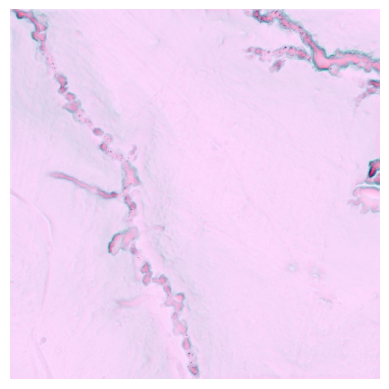

Tile 61000_1951500.jpeg created ! ✅ 


In [ ]:
create_tile('61000_1951500')

Create tile 61500_1952000's jpeg image


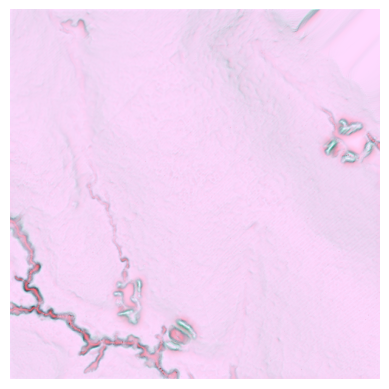

Tile 61500_1952000.jpeg created ! ✅ 


In [ ]:
create_tile('61500_1952000')

In [ ]:
# List all files in the folder
files = os.listdir(f'{path}/point_cloud_tiles/')
files = [file_name[:-4] if file_name.endswith(".laz") else file_name for file_name in files]
files

['61500_1950500',
 '61500_1952500',
 '61000_1951000',
 '61500_1949500',
 '61500_1950000',
 '61000_1951500',
 '61500_1951000',
 '61500_1951500',
 '.ipynb_checkpoints']

Create tile 61500_1950500's jpeg image


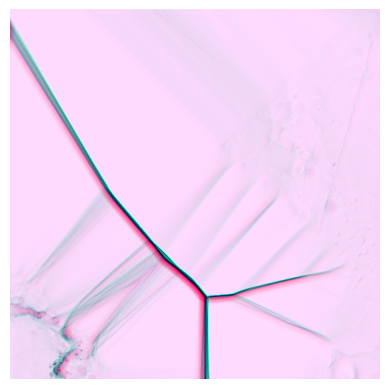

Tile 61500_1950500.jpeg created ! ✅ 
Create tile 61500_1952500's jpeg image


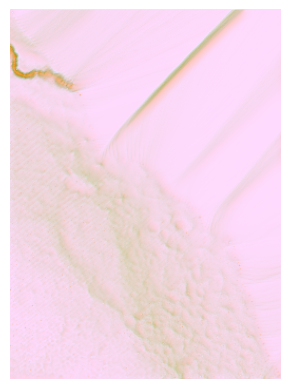

Tile 61500_1952500.jpeg created ! ✅ 
Create tile 61000_1951000's jpeg image


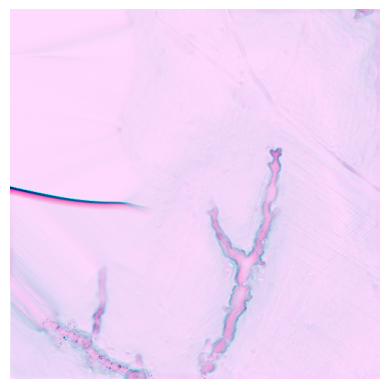

Tile 61000_1951000.jpeg created ! ✅ 
Create tile 61500_1949500's jpeg image


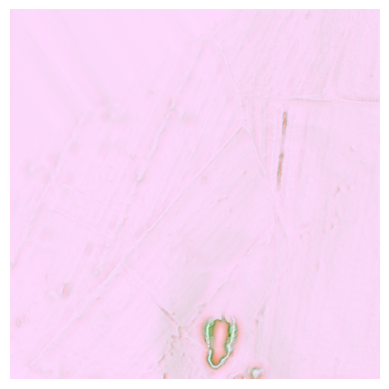

Tile 61500_1949500.jpeg created ! ✅ 
Create tile 61500_1950000's jpeg image


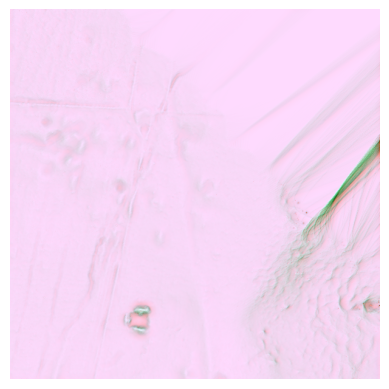

Tile 61500_1950000.jpeg created ! ✅ 
Create tile 61000_1951500's jpeg image


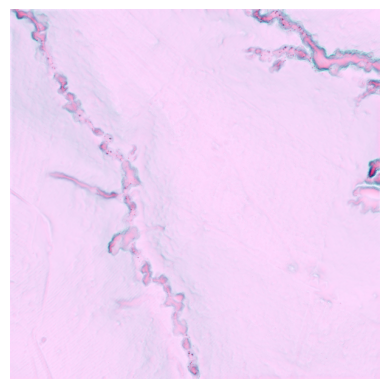

Tile 61000_1951500.jpeg created ! ✅ 
Create tile 61500_1951000's jpeg image


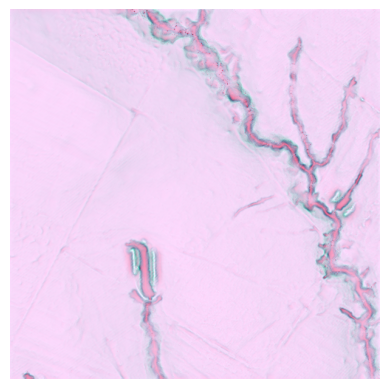

Tile 61500_1951000.jpeg created ! ✅ 
Create tile 61500_1951500's jpeg image


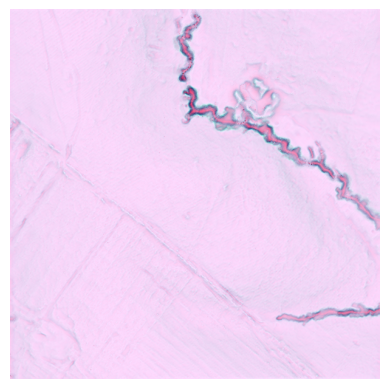

Tile 61500_1951500.jpeg created ! ✅ 


FileNotFoundError: ignored

In [ ]:
for elt in files:
  create_tile(elt)

#GPS coordinates

In [ ]:
#Transform X and Y into longitude and latitude

# Define the source and target coordinate systems
source_crs = pyproj.CRS.from_epsg(32615)  # WGS 1984 UTM Zone 15N
target_crs = pyproj.CRS.from_epsg(4326)   # WGS84 latitude/longitude

# Create a transformation object
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Example coordinate transformation
x = 661499.94  # Replace with your UTM x-coordinate
y = 1952370.92  # Replace with your UTM y-coordinate
lon, lat = transformer.transform(x, y)

# Output the transformed longitude and latitude
print(f"Longitude: {lon}")
print(f"Latitude: {lat}")

Longitude: -91.47754166144979
Latitude: 17.652319018787985


In [ ]:
#Load tile and create df and calculate longitude and latitude
tile_name = '61000_1951000'
las_file = laspy.read(f"{path}/point_cloud_tiles/{tile_name}.laz")
points = np.vstack((las_file.x, las_file.y, las_file.z)).transpose()
df_points = pd.DataFrame(points, columns = ['x','y','z'])
df_points['longitude'], df_points['latitude'] = transformer.transform(df_points['x'], df_points['y'])
df_points.head(20)


,x,y,z,longitude,latitude
0,661496.97,1951499.48,37.01,-91.477636,17.644445
1,661497.17,1951499.24,37.03,-91.477634,17.644443
2,661496.84,1951499.82,39.21,-91.477637,17.644448
3,661497.39,1951498.97,37.04,-91.477632,17.644440
4,661497.08,1951499.51,39.04,-91.477635,17.644445
5,661497.60,1951498.72,37.00,-91.477630,17.644438
6,661497.32,1951499.21,38.93,-91.477633,17.644443
7,661497.81,1951498.46,36.99,-91.477628,17.644436
8,661497.52,1951498.97,38.99,-91.477631,17.644440
9,661498.04,1951498.19,36.99,-91.477626,17.644433


In [ ]:
# Create a folium map centered on the specified coordinates lat, lon
map = folium.Map(location=[lat, lon], zoom_start=10)
folium.Marker([latitude, longitude]).add_to(map)
map
